# Inaugural Project

Do imports and set magics. Also filter warnings due to the usage of `inf` in ndarrays.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize
import warnings
from IPython.display import clear_output

%load_ext autoreload
%autoreload 2

from  inauguralproject import HouseholdSpecializationModelClass

warnings.filterwarnings('ignore', message='divide by zero encountered in reciprocal')
warnings.filterwarnings("ignore", message="delta_grad == 0.0. Check if the approximated function is linear.")
warnings.filterwarnings('ignore', message='invalid value encountered in double_scalars')

<br><br>
# Question 1

To solve the first question we need to adapt the original code to include situations when sigma is not equal to 1.

This is implemented in the section `#b. home production` of `def calc_utility(self,LM,HM,LF,HF)` inside of `inauguralproject.py`.

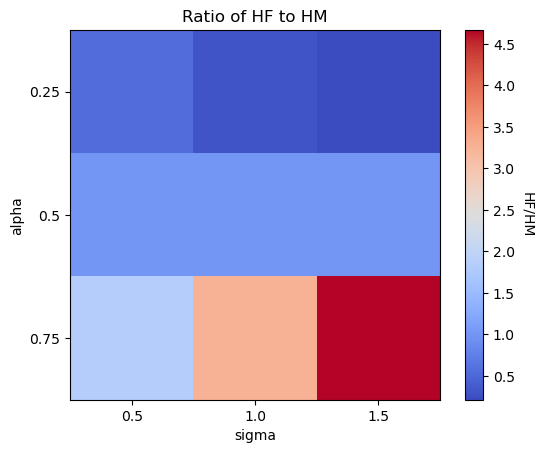

In [2]:
# initialize model
model = HouseholdSpecializationModelClass()

# values of alpha and sigma to investigate
alpha_vals = [0.25, 0.5, 0.75]
sigma_vals = [0.5, 1.0, 1.5]

# initialize array to store ratios
ratios = np.zeros((len(alpha_vals), len(sigma_vals)))

# loop over alpha and sigma values
for i, alpha in enumerate(alpha_vals):
    for j, sigma in enumerate(sigma_vals):
        
        # set alpha and sigma in the model
        model.par.alpha = alpha
        model.par.sigma = sigma
        
        # solve the model
        opt = model.solve_discrete()
        
        # calculate and save the ratio
        ratio = opt.HF / opt.HM
        ratios[i, j] = ratio

# plot heatmap
fig, ax = plt.subplots()
im = ax.imshow(ratios, cmap='coolwarm')

# set title, axis labels
_ = ax.set(title='Ratio of HF to HM', xlabel='sigma', xticks=np.arange(len(sigma_vals)), xticklabels=sigma_vals, ylabel='alpha', yticks=np.arange(len(alpha_vals)), yticklabels=alpha_vals)

# add colorbar
cbar = fig.colorbar(im, ax=ax)
_ = cbar.ax.set_ylabel('HF/HM', rotation=-90, va="bottom")

The resulting illustration is a heatmap that shows the ratio of female household production to male household production (HF/HM) for different values of alpha and sigma. 

By analyzing the heatmap, it is possible to observe that when alpha = 0.75, the ratio of HF to HM is increasing in sigma. This means that female household production is relatively more important in these cases. On the other hand, for low values of alpha, the ratio of HF to HM is decreasing in sigma, indicating that male household production is relatively more important. Changes in sigma are irrelevant when alpha = 0.5.

<br><br>
# Question 2

 To plot $\log\frac{H_{F}}{H_{M}}$ against $\log\frac{w_{F}}{w_{M}}$ for $w_{F}\in[0.8,0.9,1.0,1.1,1.2]$, we first need to solve the model for each value of $w_F$ in the range. We can do this using the `solve_wF_vec` method with the discrete parameter set to `True`. We then apply `np.log` to the solutions arrays, and plot them against one another.

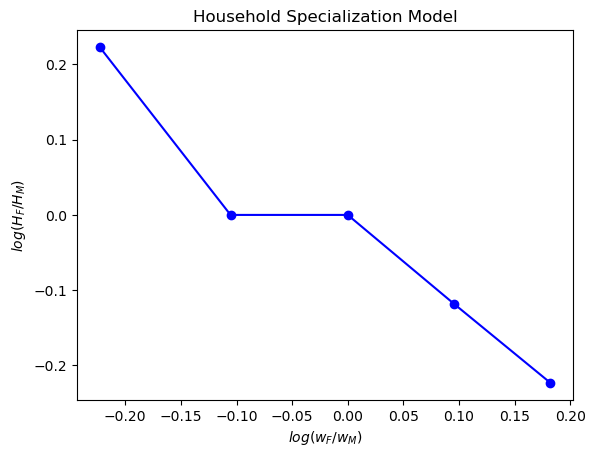

In [3]:

# initialize model
model = HouseholdSpecializationModelClass()

# solve model for each value of wF
model.solve_wF_vec(discrete=True)

# calculate log(HF/HM) and log(wF/wM)
log_HFHM = np.log(model.sol.HF_vec/model.sol.HM_vec)
log_wFwM = np.log(model.par.wF_vec/model.par.wM)

# create plot
_, ax = plt.subplots()
ax.plot(log_wFwM, log_HFHM, 'bo-')
_ = ax.set(xlabel='$log(w_F/w_M)$', ylabel='$log(H_F/H_M)$', title='Household Specialization Model')


As shown, as women's wages increase in relation to men's wages, women spend less time working at home, as their time can be more productive in the market.

<br><br>

# Question 3

To plot $\log\frac{H_{F}}{H_{M}}$ against $\log\frac{w_{F}}{w_{M}}$ for $w_{F}\in[0.8,0.9,1.0,1.1,1.2]$, we need to solve the model for each value of $w_F$ in the range. Here we use the same approach as the previous question, but this time with the discrete parameter set to false. This way the model will be solved using the continuous method, which has been added to `inauguralproject.py` at the section `def solve(self,do_print=False)`.

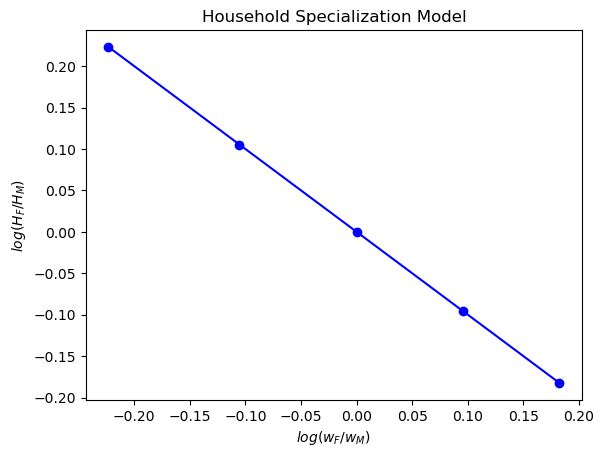

In [4]:
# initialize model
model = HouseholdSpecializationModelClass()

# solve model for each value of wF
model.solve_wF_vec(discrete=False)

# calculate log(HF/HM) and log(wF/wM)
log_HFHM = np.log(model.sol.HF_vec/model.sol.HM_vec)
log_wFwM = np.log(model.par.wF_vec/model.par.wM)

# create plot
_, ax = plt.subplots()
ax.plot(log_wFwM, log_HFHM, 'bo-')
_ = ax.set(xlabel='$log(w_F/w_M)$', ylabel='$log(H_F/H_M)$', title='Household Specialization Model')


When discrete=False, the solve_wF_vec method solves the model for a continuous range of values of wF, rather than a discrete set of values. This results in a smoother curve in the plot, when comparing to the previous plot. Obtaining the same interpretation as the previous question.

# Question 4

To match the data from Siminski and Yetsenga (2022), we set up an objective function which finds the difference between the model and the data for some values of `alpha` and `sigma`. We then minimize this objective using the `scipy.minimize` package.

In [5]:
# initialize model
model = HouseholdSpecializationModelClass()

#define objective to minimize error in beta0 and beta1
def obj(x):
    model.par.alpha = x[0]
    model.par.sigma = x[1]

    model.solve_wF_vec()
    model.run_regression()
    beta0_hat = model.sol.beta0
    beta1_hat = model.sol.beta1
    
    return (model.par.beta0_target - beta0_hat)**2 + (model.par.beta1_target - beta1_hat)**2 

In [6]:
#run optimizer (in a seperate cell because it takes some time to run)
bounds = [(0.8,0.99), (0.02, 0.20)]
res = optimize.minimize(obj, (0.9,0.15), method='Nelder-Mead', bounds=bounds)

print('To achieve beta0 = 0.4 and beta1 = -0.1,')
print(f'alpha = {res.x[0]:5.4f}\nsigma = {res.x[1]:5.4f}')

To achieve beta0 = 0.4 and beta1 = -0.1,
alpha = 0.9820
sigma = 0.1000


To fit the data, we need to have a high value for alpha (~0.98) and a low value for sigma (~0.1).

$α/(1-α)$ is the productivity in home production for females relative to males, therefore to fit the data women must be significantly more productive than men in the home. The low value of sigma means that there is a low elasticity of substitution between men and women at home. 

As illustrated below, under the assumption that they both work for 8 hours, the women have a significantly higher level of productivity when working at home, in accordance with the model. Hence, it is both economically and econometrically consistent, for the given the true parameter values, that the women should be working more hours in the home whilst the men should be investing their work hours mainly in the labour market.
 

In [7]:
choice_sigma = 0.1
choice_alpha = 0.9820
mh, wh = 8, 8

man = (1-choice_alpha)*(mh ** (choice_sigma-1)/choice_sigma)
wom = choice_alpha*(wh ** (choice_sigma-1)/choice_sigma)

print(f"Man's productivity is {man:8.4f}")
print(f"Woman's productivity is {wom:5.4f}")

Man's productivity is   0.0277
Woman's productivity is 1.5112


<br><br>
# Question 5

Our findings so far, however, are far from realistic given the gaping chasm of difference between the productivity of men and women at home represented by a high value of alpha. This leaves room for improvement in the model to better reflect the real world.

Setting alpha = 0.5, (which negates the effect of sigma except when sigma = 0 or 1), an alternative method of matching the data is to introduce additional disutility to working in the home. We now formulate the maximisation problem as:

$\max_{L_M, H_M, L_F, H_F} \frac{Q^{1-\rho}}{1-\rho} - \nu \left(T_M^{1+\frac{1}{\epsilon}} + T_F^{1+\frac{1}{\epsilon}} \right) - \nu_{M} \frac{H_M^{1+\frac{1}{\epsilon}}}{1+\frac{1}{\epsilon}} - \nu_{F} \frac{H_F^{1+\frac{1}{\epsilon}}}{1+\frac{1}{\epsilon}}$

where $\nu_{M}$ and $\nu_{F}$ are the weights on the additional disutility of household labor gained by the man and woman respectively. 

We can now set up a minimiser and solve for the values of $\nu_{M}$ and $\nu_{F}$ that make the model best match the data.

In [8]:
# initalise model
model = HouseholdSpecializationModelClass()
model.par.alpha = 0.5
model.par.sigma = 0.5

# introduce additional disutility of household labor
model.par.include_additional_disutil = True

# define objective function to minimise difference between model and data
def obj(x):
    model.par.disutil_HM = x[0]
    model.par.disutil_HF = x[1]

    model.solve_wF_vec()
    model.run_regression()

    diff = (model.par.beta0_target - model.sol.beta0)**2 + (model.par.beta1_target - model.sol.beta1)**2
    clear_output(wait=True)
    print(f'{"v_HF":7}{"v_HM":7}   {"b0":7}{"b1":7}{"diff":7}')
    print(f'{x[0]:<7.2f}{x[1]:<7.2f}   {model.sol.beta0:<7.2f}{model.sol.beta1:<7.2f}{diff:<7.3f}')
    return diff

In [9]:
# solve
res = optimize.minimize(obj, (0.0315, 0.007), method='trust-constr', bounds=optimize.Bounds([0.0001, 0.0001],[0.05, 0.05], keep_feasible=True), options={})
print(f'\nAnswer:\n{res.x[0]:<7.4f}   {res.x[1]:<7.4f}')

#solution: 0.03125889 0.00712304

v_HF   v_HM      b0     b1     diff   
0.03   0.01      0.40   -0.10  0.000  

Answer:
0.0313    0.0071 


We find the solution at:
$\nu_{M} \approx 0.031 $ and $\nu_{F} \approx 0.007$

This shows that, to fit the data, male disutility of household labour in this model is significantly higher than female disutility. We can perhaps think of this difference as the product of societal norms and expectations for the self. Men grow up less willing to do household labor than women. Thus, although both agents experience disutility from household labor, when utility is maximised for the household, the woman will end up doing more labor.


In [10]:
origmodel = HouseholdSpecializationModelClass()
origmodel.par.alpha = 0.982
origmodel.par.sigma = 0.1
origmodel.solve_wF_vec()
origmodel.run_regression()

print(f'{"":10}{"LM":6}{"LF":6}{"HM":6}{"HF":6}')
print(f'{"original":10}{np.mean(origmodel.sol.LM_vec):<6.1f}{np.mean(origmodel.sol.LF_vec):<6.1f}{np.mean(origmodel.sol.HM_vec):<6.1f}{np.mean(origmodel.sol.HF_vec):<6.1f}')
print(f'{"extended":10}{np.mean(model.sol.LM_vec):<6.1f}{np.mean(model.sol.LF_vec):<6.1f}{np.mean(model.sol.HM_vec):<6.1f}{np.mean(model.sol.HF_vec):<6.1f}')

          LM    LF    HM    HF    
original  5.2   3.4   3.5   5.2   
extended  7.0   6.2   1.3   2.0   


In the extended model, both agents do far fewer hours of work in the home on average. As shown above, women do on average 2 hours of household labor, while men do on average 1.3 hours, versus 5.2 and 3.5 hours in the previous model.

These new numbers are much more convincing, in particular the fact that both agents do 1-2 hours of household labor per day, with men doing around 40 minutes less than women. Therefore this model is probably a better fit for the data in Siminski and Yetsenga (2022) than previously.